In [5]:
import json
import os
from pathlib import Path
import time
import copy

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from fastai.dataset import open_image
import json
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import cv2
from tqdm import tqdm

In [6]:
# params
SIZE = 224
EPOCHS = 5
BATCH_SIZE = 32
NUM_WORKERS = 4
SHOW_IMAGES = False

# static
IMAGES = 'images'
ANNOTATIONS = 'annotations'
CATEGORIES = 'categories'
ID = 'id'
NAME = 'name'
IMAGE_ID = 'image_id'
BBOX = 'bbox'
CATEGORY_ID = 'category_id'
FILE_NAME = 'file_name'
IMAGE = 'image'
CATEGORY = 'category'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print('device:', device)

device: cuda:0


Adjust data dir path for Paperspace or Kaggle

In [8]:
home_dir = os.path.expanduser('~')

if home_dir == '/home/paperspace':
    DATA_DIR = '/home/paperspace/data/pascal'
else: # kaggle
    DATA_DIR = '../input/pascal/pascal'

In [9]:
PATH = Path(DATA_DIR)
list(PATH.iterdir())

[PosixPath('/home/paperspace/data/pascal/VOCdevkit'),
 PosixPath('/home/paperspace/data/pascal/ImageSets'),
 PosixPath('/home/paperspace/data/pascal/pascal_train2007.json'),
 PosixPath('/home/paperspace/data/pascal/SegmentationObject'),
 PosixPath('/home/paperspace/data/pascal/pascal_test2007.json'),
 PosixPath('/home/paperspace/data/pascal/pascal_val2012.json'),
 PosixPath('/home/paperspace/data/pascal/SegmentationClass'),
 PosixPath('/home/paperspace/data/pascal/Annotations'),
 PosixPath('/home/paperspace/data/pascal/pascal_val2007.json'),
 PosixPath('/home/paperspace/data/pascal/pascal_train2012.json'),
 PosixPath('/home/paperspace/data/pascal/models'),
 PosixPath('/home/paperspace/data/pascal/JPEGImages'),
 PosixPath('/home/paperspace/data/pascal/tmp')]

In [10]:
train_data = json.load((PATH/'pascal_train2007.json').open())
val_data = json.load((PATH/'pascal_val2007.json').open())
test_data = json.load((PATH/'pascal_test2007.json').open())

print('train:', train_data.keys())
print('val:', val_data.keys())
print('test:', test_data.keys())

train: dict_keys(['images', 'type', 'annotations', 'categories'])
val: dict_keys(['images', 'type', 'annotations', 'categories'])
test: dict_keys(['images', 'type', 'annotations', 'categories'])


In [11]:
train_data[ANNOTATIONS][:1]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0}]

In [12]:
train_data[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}]

In [13]:
len(train_data[CATEGORIES])

20

In [14]:
next(iter(train_data[CATEGORIES]))

{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}

In [15]:
categories = {c[ID]:c[NAME] for c in train_data[CATEGORIES]}

# all categories are the same
val_categories = {c[ID]:c[NAME] for c in val_data[CATEGORIES]}
test_categories = {c[ID]:c[NAME] for c in test_data[CATEGORIES]}
assert categories == val_categories == test_categories

print('category count:', len(categories))
print(categories)

category count: 20
{1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}


In [16]:
IMAGE_PATH = Path(PATH/'JPEGImages/')
list(IMAGE_PATH.iterdir())[:2]

[PosixPath('/home/paperspace/data/pascal/JPEGImages/006948.jpg'),
 PosixPath('/home/paperspace/data/pascal/JPEGImages/005796.jpg')]

Helper functions for setting up `pandas.DataFrame` fed to the torch `Dataset`

In [17]:
def get_filenames(data):
    filenames = {o[ID]:o[FILE_NAME] for o in data[IMAGES]}
    print('get_id_filename_dict')
    print('length:', len(filenames), 'next item:', next(iter(filenames.items())))
    return filenames

In [18]:
def get_image_ids(data):
    image_ids = [o[ID] for o in data[IMAGES]]
    print('get_image_ids')
    print('length:', len(image_ids), 'next item:', image_ids[0])
    return image_ids

In [19]:
def pascal_bb_hw(bb):
    return bb[2:]

bbox = train_data[ANNOTATIONS][0][BBOX]
pascal_bb_hw(bbox)

[196, 174]

In [20]:
def get_image_w_area(data, image_ids):
    image_w_area = {i:None for i in image_ids}
    image_w_area = copy.deepcopy(image_w_area)
    for x in data[ANNOTATIONS]:
        bbox = x[BBOX]
        new_category_id = x[CATEGORY_ID]
        image_id = x[IMAGE_ID]
        h, w = pascal_bb_hw(bbox)
        new_area = h*w
        cat_id_area = image_w_area[image_id]
        if not cat_id_area:
            image_w_area[image_id] = (new_category_id, new_area)
        else:
            category_id, area = cat_id_area
            if new_area > area:
                image_w_area[image_id] = (new_category_id, new_area)
    print('get_image_w_area')
    print('length:', len(image_w_area), 'next item:', next(iter(image_w_area.items())))
    return image_w_area

train data structs

In [21]:
train_filenames = get_filenames(train_data)
train_image_ids = get_image_ids(train_data)
train_image_w_area = get_image_w_area(train_data, train_image_ids)

get_id_filename_dict
length: 2501 next item: (12, '000012.jpg')
get_image_ids
length: 2501 next item: 12
get_image_w_area
length: 2501 next item: (12, (7, 34104))


## Locate the largest object's bbox

In [22]:
train_data[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [23]:
def get_image_w_bbox(data, image_ids):
    image_w_bbox = {i:None for i in image_ids}
    for x in data[ANNOTATIONS]:
        new_bbox = x[BBOX]
        new_category_id = x[CATEGORY_ID]
        image_id = x[IMAGE_ID]
        h, w = pascal_bb_hw(new_bbox)
        new_area = h*w
        existing = image_w_bbox[image_id]
        if not existing:
            image_w_bbox[image_id] = (new_area, new_bbox, new_category_id)
        else:
            area, *_, area = existing
            if new_area > area:
                image_w_bbox[image_id] = (new_area, new_bbox, new_category_id)
    return image_w_bbox

image_w_bbox = get_image_w_bbox(train_data, train_image_ids)

## Image functions

In [24]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

show image with bbox - using the above image functions

[155, 96, 196, 174]


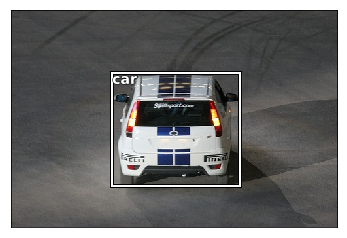

In [25]:
image_id, (area, bbox, cat) = next(iter(image_w_bbox.items()))
fn = f'{IMAGE_PATH}/{train_filenames[image_id]}'
im = open_image(fn)
ax = show_img(im)
b = bbox
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[cat])

In [26]:
def scale_pascal_bb(bbox, image, size):
    """
    Returns a bbox scaled to the target `size`
    
    Args:
        bbox (1d array): pascal_bb [x, y, x2, y2]
        image (3d array): HWC
        size (scalar): target image size that bbox should be scaled to
    """
    im_w = image.shape[1]
    im_h = image.shape[0]
    return np.multiply(np.divide(bbox, [im_w, im_h, im_w, im_h]), size)

[ 69.44     64.57658  87.808   117.04505]


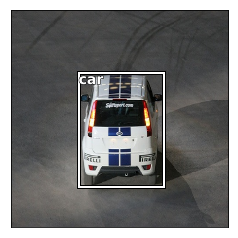

In [27]:
image_id, (area, bbox, cat) = next(iter(image_w_bbox.items()))
fn = f'{IMAGE_PATH}/{train_filenames[image_id]}'
im = open_image(fn)
resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
ax = show_img(resized_image)
size=224
b = scale_pascal_bb(bbox, im, size)
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[cat])

# Dataset

Scales image to (3, 224, 224) for Resnet18

Also scales the bbox

In [28]:
next(iter(train_filenames.items()))

(12, '000012.jpg')

In [29]:
def get_full_filenames(id_filename_dict):
    """
    Returns a list of 2 item tuples (image_id, image_full_path)
    
    Args:
        id_filename_dict (dict): {image_id: filename}
    """
    return [
         (k, f'{IMAGE_PATH}/{v}')
      for k,v in id_filename_dict.items()]

train_full_filenames = get_full_filenames(train_filenames)

In [30]:
tff = next(iter(train_full_filenames))
tff

(12, '/home/paperspace/data/pascal/JPEGImages/000012.jpg')

In [31]:
open_image(tff[1]).shape

(333, 500, 3)

In [32]:
class BboxDataset(Dataset):
    def __init__(self, full_filenames, data_bbox):
        """
        Args:
            full_filenames (list): [(image_id, image_full_path), ...]
            data_bbox (dict): {image_id: (area, bbox, cat), ...}
        """
        self.full_filenames = full_filenames
        self.data_bbox = data_bbox

    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image_id, image_path = self.full_filenames[idx]
        im = open_image(image_path) # HW
        resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
        image = np.transpose(resized_image, (2, 0, 1)) # CHW
        
        _, bbox, cat = self.data_bbox[image_id]
        scaled_bbox = scale_pascal_bb(bbox, im, SIZE)

        return image_id, image, (scaled_bbox, cat)
    
dataset = BboxDataset(train_full_filenames, image_w_bbox)
idx = 0
image_id, inputs, label = dataset[0]

In [33]:
inputs.shape

(3, 224, 224)

In [34]:
label

(array([ 69.44   ,  64.57658,  87.808  , 117.04505]), 7)

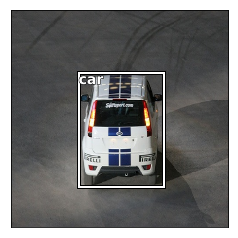

In [35]:
def show_image_and_bbox(inputs, label):
    """
    Args:
        inputs (3d ndarray): CHW
        label (list): [bbox, category_id]
    """
    ax = show_img(np.transpose(inputs, (1, 2, 0)))
    (bbox, cat) = label
    draw_rect(ax, bbox)
    draw_text(ax, bbox[:2], categories[cat])
        
show_image_and_bbox(inputs, label)

### Val Dataset

val data structs

In [36]:
val_filenames = get_filenames(val_data)
val_image_ids = get_image_ids(val_data)
val_image_w_area = get_image_w_area(val_data, val_image_ids)

get_id_filename_dict
length: 2510 next item: (5, '000005.jpg')
get_image_ids
length: 2510 next item: 5
get_image_w_area
length: 2510 next item: (5, (9, 9701))


In [37]:
val_full_filenames = get_full_filenames(val_filenames)
next(iter(val_full_filenames))

(5, '/home/paperspace/data/pascal/JPEGImages/000005.jpg')

In [38]:
val_image_w_bbox = get_image_w_bbox(val_data, val_image_ids)

In [39]:
val_dataset = BboxDataset(val_full_filenames, val_image_w_bbox)

In [40]:
def preview_data(data):
    if isinstance(data, (list, tuple)):
        return data[0]
    elif isinstance(data, dict):
        return next(iter(data.items()))
    else:
        raise TypeError(f"Unsupported type: {type(data)}")

In [41]:
preview_data(val_filenames)

(5, '000005.jpg')

In [42]:
val_data[ANNOTATIONS][0]

{'segmentation': [[262, 210, 262, 339, 324, 339, 324, 210]],
 'area': 7998,
 'iscrowd': 0,
 'image_id': 5,
 'bbox': [262, 210, 62, 129],
 'category_id': 9,
 'id': 1,
 'ignore': 0}

In [43]:
val_image_w_bbox = get_image_w_bbox(val_data, val_image_ids)
preview_data(val_image_w_bbox)

(5, (1260, [276, 185, 36, 35], 9))

In [44]:
print(preview_data(val_full_filenames))
print(preview_data(val_image_w_bbox))

(5, '/home/paperspace/data/pascal/JPEGImages/000005.jpg')
(5, (1260, [276, 185, 36, 35], 9))


In [45]:
val_dataset = BboxDataset(val_full_filenames, val_image_w_bbox)
idx = 2
image_id, inputs, label = val_dataset[idx]
image_id, inputs.shape, label

(9, (3, 224, 224), (array([115.136  , 117.67467,  17.92   ,  78.848  ]), 15))

In [46]:
label

(array([115.136  , 117.67467,  17.92   ,  78.848  ]), 15)

show Validation dataset image w/ bbox

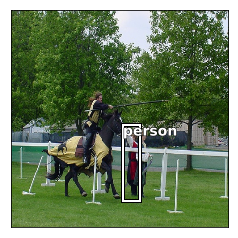

In [47]:
show_image_and_bbox(inputs, label)

Show the above image at **full scale** for the ground truth to see if it's correct

In [48]:
idx = 2
image_id, filename = val_full_filenames[idx]
image_id, filename

(9, '/home/paperspace/data/pascal/JPEGImages/000009.jpg')

In [49]:
area, bbox, cat = val_image_w_bbox[image_id]
area, bbox, cat

(5280, [257, 197, 40, 132], 15)

In [50]:
categories[cat]

'person'

In [51]:
im = open_image(filename)
im.shape

(375, 500, 3)

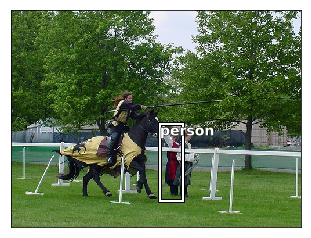

In [52]:
ax = show_img(im)
draw_rect(ax, bbox)
draw_text(ax, bbox[:2], categories[cat])

bbox helper functions

In [53]:
def fastai_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

print(bbox)
print(fastai_bb(bbox))

[257, 197, 40, 132]
[197 257 328 296]


In [58]:
def pascal_bb_hw(bb):
    return bb[2:]

bbox = train_data[ANNOTATIONS][0][BBOX]
pascal_bb_hw(bbox)

[196, 174]

# DataLoader

In [59]:
BATCH_SIZE = 64
NUM_WORKERS = 0

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=NUM_WORKERS)

batch_image_ids, batch_inputs, batch_labels = next(iter(dataloader))

In [60]:
batch_inputs.size()

torch.Size([64, 3, 224, 224])

In [61]:
# batch_labels is a list, the first item is the "batch bbox's", 2nd item is "batch categories"

In [62]:
len(batch_labels)

2

In [63]:
batch_labels[0].size()

torch.Size([64, 4])

In [64]:
batch_labels[1].size()

torch.Size([64])

In [65]:
# train the model

In [66]:
NUM_CATEGORIES = len(categories)
NUM_CATEGORIES

20

Val DataLoader

In [67]:
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=NUM_WORKERS)

Device check

In [68]:
print('DEVICE:', device)

DEVICE: cuda:0


# Build model

In [69]:
model_ft = models.resnet18(pretrained=True)

for layer in model_ft.parameters():
    layer.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
IN_FEATURES = num_ftrs

print(IN_FEATURES, NUM_CATEGORIES)

# model_ft.fc = nn.Linear(num_ftrs, NUM_CATEGORIES)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

512 20


# Custom head with single Layer fork to 2 outputs

`[bbox preds, category preds]`

In [70]:
class BboxAndCatLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.cat_layer = nn.Linear(IN_FEATURES, NUM_CATEGORIES)
        self.bbox_layer = nn.Linear(IN_FEATURES, 4)
        
    def forward(self, x):
        return (self.bbox_layer(x), self.cat_layer(x), )
    
model_ft.fc = BboxAndCatLayer()

model_ft = model_ft.to(device)

### check Model output dimen

In [71]:
image_ids, inputs, labels = next(iter(dataloader))

In [72]:
print(len(labels))
print(type(labels))
print(labels[0].size())
print(labels[0].dtype)
print(labels[1].size())
print(labels[1].dtype)

2
<class 'list'>
torch.Size([64, 4])
torch.float64
torch.Size([64])
torch.int64


In [77]:
inputs = inputs.to(device)
outputs = model_ft(inputs)

In [83]:
bbox_outputs, cat_outputs = outputs
bbox_outputs.size(), cat_outputs.size()

(torch.Size([64, 4]), torch.Size([64, 20]))

In [84]:
_, cat_preds = torch.max(cat_outputs, dim=1)
cat_preds.size()

torch.Size([64])

In [85]:
preds = [bbox_outputs, cat_outputs]

print(preds[0].size())
print(preds[0].dtype)
print(preds[1].size())
print(preds[1].dtype)

torch.Size([64, 4])
torch.float32
torch.Size([64, 20])
torch.float32


# Loss Function - for custom head

In [86]:
class BboxAndCatLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bbox_loss = nn.L1Loss()
        self.cat_loss = nn.CrossEntropyLoss()
        
    def forward(self, preds, targets):
        bbox_preds, cat_preds = preds
        bbox_targets, cat_targets = targets

        # data munging
        bbox_preds = bbox_preds.to(device, torch.float64)
        cat_targets_0_indexed = cat_targets - 1
        
        # per type of loss
        bbox_loss = self.bbox_loss(bbox_preds, bbox_targets)
        cat_loss = self.cat_loss(cat_preds, cat_targets_0_indexed)
        # cast b/c bbox_loss.dtype == torch.float64
        cat_loss = cat_loss.to(device, dtype=torch.float64)
        
        return bbox_loss + cat_loss
    
criterion = BboxAndCatLoss()

preds = [p.to(device) for p in preds]
labels = [x.to(device) for x in labels]

loss = criterion(preds, labels)
loss

tensor(86.2078, device='cuda:0', dtype=torch.float64, grad_fn=<ThAddBackward>)

# Train the model

In [87]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

In [88]:
TRAIN = 'train'
VAL = 'val'

dataloaders = {
    TRAIN: dataloader,
    VAL: val_dataloader
}

dataset_sizes = {
    TRAIN: len(dataset),
    VAL: len(val_dataset)
}

In [ ]:
epoch_losses = {TRAIN: [], VAL: []}
epoch_accuracies = {TRAIN: [], VAL: []}

In [94]:
EPOCHS = 5

for epoch in tqdm(range(EPOCHS)):
    print('epoch:', epoch)
    
    for phase in [TRAIN, VAL]:
        running_loss = 0.0
        running_correct = 0

        for image_ids, inputs, labels in dataloader:
            inputs = inputs.to(device)

            # labels - separate to.(device) b/c labels is a list
            (bbox_labels, cat_labels) = labels
            bbox_labels = bbox_labels.to(device)
            cat_labels = cat_labels.to(device)

            # clear gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model_ft(inputs)
            bbox_outputs, cat_outputs = outputs
            _, preds = torch.max(cat_outputs, dim=1)
            labels = [x.to(device) for x in labels]
            loss = criterion(outputs, labels)

            # backwards pass
            if phase == TRAIN:
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            labels_0_indexed = cat_labels - 1
            running_correct += torch.sum(preds == labels_0_indexed)

        # per epoch/phase
        epoch_loss = running_loss / len(dataset)
        epoch_acc = running_correct.double().item() / len(dataset)
        epoch_losses[phase].append(epoch_loss)
        epoch_accuracies[phase].append(epoch_acc)
    print('train loss:', epoch_losses[TRAIN][epoch], 'train acc:', epoch_accuracies[TRAIN][epoch],
          'val loss:', epoch_losses[VAL][epoch], 'val acc:', epoch_accuracies[VAL][epoch])

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0


 20%|██        | 1/5 [00:34<02:17, 34.30s/it]

train loss: 45.244874100743225 train acc: 0.728108756497401 val loss: 44.74829188442624 val acc: 0.7536985205917633
epoch: 1


 40%|████      | 2/5 [01:08<01:43, 34.38s/it]

train loss: 44.71776828744181 train acc: 0.7429028388644542 val loss: 44.32825960269152 val acc: 0.743702518992403
epoch: 2


 60%|██████    | 3/5 [01:42<01:08, 34.20s/it]

train loss: 44.27103224291613 train acc: 0.7465013994402239 val loss: 43.88994476409424 val acc: 0.764094362255098
epoch: 3


 80%|████████  | 4/5 [02:16<00:34, 34.19s/it]

train loss: 43.82102282430118 train acc: 0.7684926029588165 val loss: 43.35220664267839 val acc: 0.7680927628948421
epoch: 4


100%|██████████| 5/5 [02:50<00:00, 34.20s/it]

train loss: 43.35933244915034 train acc: 0.7692922830867653 val loss: 43.11224241213748 val acc: 0.795281887245102


Graph loss and accuracy

In [95]:
epoch_losses

{'train': [45.244874100743225,
  44.71776828744181,
  44.27103224291613,
  43.82102282430118,
  43.35933244915034],
 'val': [44.74829188442624,
  44.32825960269152,
  43.88994476409424,
  43.35220664267839,
  43.11224241213748]}

In [96]:
epoch_accuracies

{'train': [0.728108756497401,
  0.7429028388644542,
  0.7465013994402239,
  0.7684926029588165,
  0.7692922830867653],
 'val': [0.7536985205917633,
  0.743702518992403,
  0.764094362255098,
  0.7680927628948421,
  0.795281887245102]}

In [97]:
# check predictions

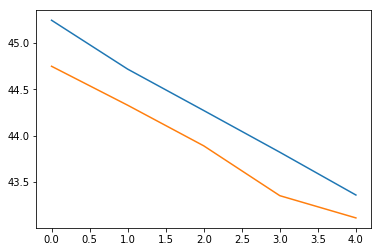

In [98]:
plt.plot(epoch_losses['train'])
plt.plot(epoch_losses['val'])

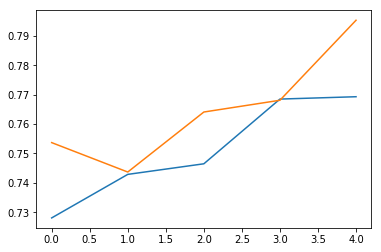

In [99]:
plt.plot(epoch_accuracies['train'])
plt.plot(epoch_accuracies['val'])

view predictions

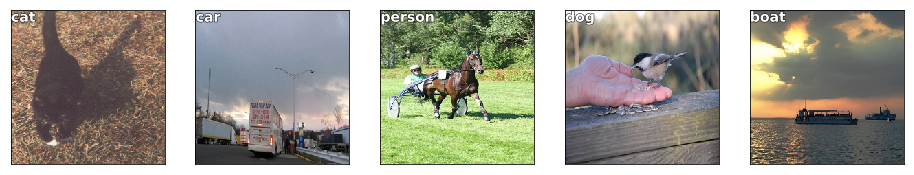

In [100]:
preds_count = len(preds)
fig, axes = plt.subplots(1, preds_count, figsize=(16, 16))
for i, ax in enumerate(axes.flat):
    im = np.transpose(inputs[i], (1, 2, 0))
    ax = show_img(im, ax=ax)
    draw_text(ax, (0,0), categories[preds[i].item()+1])

In [101]:
preds

tensor([ 7,  6, 14, 11,  3], device='cuda:0')

In [102]:
labels

[tensor([[ 28.0816,   1.7920,  70.5306, 196.6720],
         [ 76.1600, 130.7331,  52.4160,  86.8897],
         [ 34.3063,  79.2960,  34.9790,  40.3200],
         [  0.4480,  63.5224, 155.9040,  82.9134],
         [167.5520, 135.2072,  46.5920,  25.5616]],
        device='cuda:0', dtype=torch.float64),
 tensor([ 8,  6, 15, 15,  4], device='cuda:0')]

In [120]:
inputs.shape

torch.Size([5, 3, 224, 224])

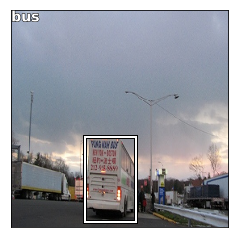

In [129]:
# fig, axes = plt.subplots(1, preds_count, figsize=(16, 16))
# for i, ax in enumerate(axes.flat):

i = 1
inp = inputs[i]
bbox = labels[0][i]
cat = labels[1][i].item()

im = np.transpose(inp, (1, 2, 0))
ax = show_img(im)
draw_rect(ax, bbox)
draw_text(ax, (0,0), categories[cat])

## NEXT - need to display predictions for visual checking

will have to unscale and reverse predictions, since format is (3, 224, 224) and bbox's scaled

In [125]:
bbox_outputs, cat_outputs = outputs
bbox_outputs

tensor([[ 43.9441,  30.4887,  98.0446, 126.5031],
        [ 42.9533,  76.0551,  66.1921,  73.6733],
        [ 62.3306,  54.9812,  58.2231,  96.1202],
        [ 52.8835,  59.3309, 123.0228, 140.0781],
        [ 69.4443,  89.1172,  50.7983,  73.7821]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)

In [127]:
cat_outputs.shape

torch.Size([5, 20])

In [128]:
_, preds = torch.max(cat_outputs, dim=1)
preds

tensor([ 7,  6, 14, 11,  3], device='cuda:0')

In [ ]:
def show_image_and_bbox(inputs, label):
    """
    Args:
        inputs (3d ndarray): CHW
        label (list): [bbox, category_id]
    """
    ax = show_img(np.transpose(inputs, (1, 2, 0)))
    (bbox, cat) = label
    draw_rect(ax, bbox)
    draw_text(ax, bbox[:2], categories[cat])

In [ ]:
preds_count = len(preds)
fig, axes = plt.subplots(1, preds_count, figsize=(16, 16))
for i, ax in enumerate(axes.flat):
    
    im = np.transpose(inputs[i], (1, 2, 0))
    ax = show_img(im, ax=ax)
    draw_text(ax, (0,0), categories[preds[i].item()+1])